In [8]:
import numpy as np
import matplotlib.pyplot as plt

from rfest.MF import semiNMF
from rfest._splines import build_spline_matrix

## Simulated Subunits

In [138]:
def gaussian(dims, sigma, mu):
    
    import numpy as onp
    
    if len(dims) == 1:
        
        x = dims[0]
        xx = onp.arange(x)
        
        gaussian_filter = 1/(sigma*onp.sqrt(2*onp.pi))*onp.exp(-1*(xx-mu)**2/ (2*sigma**2) )
        gaussian_filter = gaussian_filter.reshape(*dims, 1)
        
    else:
        
        if 1 < len(dims) < 3:
        
            x = dims[0]
            y = dims[1]
            
        elif len(dims) > 2:
            
            y = dims[1]
            x = dims[2]
        
        sigx = sigma[0]
        sigy = sigma[1]
        
        mux = mu[0]
        muy = mu[1]
        
        xx, yy = onp.meshgrid(onp.arange(0, y), onp.arange(0, x))
        
        gaussian_window = onp.exp(-0.5 * (((xx - mux) / sigx)**2 + ((yy - muy) / sigy)**2))
        gaussian_filter = 0.5 * gaussian_window / (0.5 * onp.pi * (sigx + sigy) ** 2)
        gaussian_filter = 0.25 * gaussian_filter / gaussian_filter.max()
        gaussian_filter = gaussian_filter.T
    
    return gaussian_filter.T

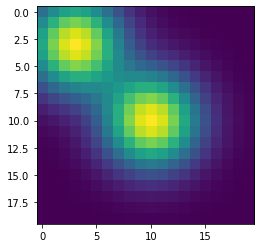

In [204]:
dims = [20, 20]

k0 = gaussian(dims, [3,3], [10, 10])
k1 = gaussian(dims, [3,3], [3, 3])

plt.imshow(k0+k1)

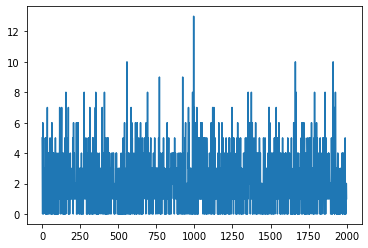

In [205]:
def nonlin(x):
    return np.log(1+np.exp(x))+1e-7

dt = 1
n = np.prod(dims) * 5
X = np.random.randn(n, *dims).reshape(n, np.prod(dims))

ci = nonlin(X @ k0.flatten()) + nonlin(X @ k1.flatten())
y = np.random.poisson(nonlin(ci) * dt)

plt.plot(y)

## Kmeans

In [206]:
def l2_distance(d, vec):    

    ret_val = np.sqrt(((d[:,:] - vec)**2.0).sum(axis=0))
            
    return ret_val.reshape((-1))

def pdist(A, B):
    # compute pairwise distance between a data matrix A (d x n) and B (d x m).
    # Returns a distance matrix d (n x m).
    d = np.zeros((A.shape[1], B.shape[1]))
    if A.shape[1] <= B.shape[1]:
        for aidx in range(A.shape[1]):
            d[aidx:aidx+1,:] = l2_distance(B[:,:], A[:,aidx:aidx+1]).reshape((1,-1))
    else:
        for bidx in range(B.shape[1]):
            d[:, bidx:bidx+1] = l2_distance(A[:,:], B[:,bidx:bidx+1]).reshape((-1,1))    
    return d

def vq(A, B):
    # assigns data samples in B to cluster centers A and
    # returns an index list [assume n column vectors, d x n]
    assigned = np.argmin(pdist(A,B), axis=0)
    return assigned


class KMeans:

    """

    Kmeans clustering. V = WH, where W is the cluster centroid, H the cluster labels.
    
    """

    def __init__(self, V, k=2, random_seed=2046, **kwargs):

        # build spline matrix, or not

        self.build_S = kwargs['build_S'] if 'build_S' in kwargs.keys() else False
        self.dims = kwargs['dims'] if self.build_S else None
        self.df = kwargs['df'] if self.build_S else None
        self.smooth = kwargs['smooth'] if 'smooth' in kwargs.keys() else 'cr'

        self.S = build_spline_matrix(self.dims, self.df, self.smooth) if self.build_S else None
        
        # store input data
        self.V = V # data
        
        # data shape / dimension
        self.m, self.n = V.shape
        self.k = k # number of subunits
        self.b = self.S.shape[1] if self.S is not None else None

        # initialize W and H

        np.random.seed(random_seed)

        self.H = np.zeros((self.n, self.k))
        self.W = self.V[:, np.sort(np.random.choice(range(self.n), self.k))]
        
    def update_W(self):
        
        V = self.V
        W = self.W
        H = self.H  
        S = self.S
        
        for i in range(self.k):
            # cast to bool to use H as an index for data
            idx = np.array(H[:, i], dtype=np.bool)
            n = np.sum(idx)
            if n > 0:
                W[:,i] = np.mean(V[:, idx], axis=1)
                
        if S is not None:
                        
            W0 = W.copy()
            
            B = np.linalg.lstsq(S, W0, rcond=None)[0]
            W = S @ B
            
        else:
            B = None
                
        return W, B
    
    def update_H(self):
        
        V = self.V
        W = self.W
        H = self.H
        
        assigned = vq(self.W, self.V)
        H = np.zeros(H.shape)
        H[range(self.n), assigned] = 1.0        
        
        return H
    
    def compute_cost(self):
        
        V = self.V
        W = self.W
        H = self.H
        WHt = W @ H.T
        
        return np.mean((V - WHt)**2)

    def fit(self, num_iters=300, verbal=0, tolerance=10):

        if verbal:
            self.cost = []
            self.iter = []
            print('{}\t{}'.format('Iter', 'Cost'))
        
        # start updating
        for itr in range(num_iters):

            self.W, self.B = self.update_W()
            self.H = self.update_H()

            if verbal:
                if itr % verbal == 0:
                    self.cost.append(self.compute_cost())
                    self.iter.append(itr)
                    print('{}\t{:.3f}'.format(itr, self.cost[-1])) 

                    if len(self.cost) >= tolerance and (np.abs(np.diff(self.cost[-tolerance:])) < 1e-7).all():
                        print('Stop: cost has been changing so small in the last ten chechpoint. Final cost = {:.3f}'.format(self.cost[-1]))
                        break
        else:
            if verbal:
                print('Stop: reached maximum iterations. Final cost = {:.3f}'.format(self.cost[-1]))

    

In [207]:
V = X[y!=0]

In [208]:
kms = KMeans(V.T, 2, build_S=True, dims=dims, df=7)

In [209]:
kms.fit(num_iters=1000, verbal=1, tolerance=100)

Iter	Cost
0	1.094
1	1.000
2	1.000
3	1.000
4	1.000
5	1.000
6	1.000
7	1.000
8	1.000
9	1.000
10	1.000
11	1.000
12	1.000
13	1.000
14	1.000
15	1.000
16	1.000
17	1.000
18	1.000
19	1.000
20	1.000
21	1.000
22	1.000
23	1.000
24	1.000
25	1.000
26	1.000
27	1.000
28	1.000
29	1.000
30	1.000
31	1.000
32	1.000
33	1.000
34	1.000
35	1.000
36	1.000
37	1.000
38	1.000
39	1.000
40	1.000
41	1.000
42	1.000
43	1.000
44	1.000
45	1.000
46	1.000
47	1.000
48	1.000
49	1.000
50	1.000
51	1.000
52	1.000
53	1.000
54	1.000
55	1.000
56	1.000
57	1.000
58	1.000
59	1.000
60	1.000
61	1.000
62	1.000
63	1.000
64	1.000
65	1.000
66	1.000
67	1.000
68	1.000
69	1.000
70	1.000
71	1.000
72	1.000
73	1.000
74	1.000
75	1.000
76	1.000
77	1.000
78	1.000
79	1.000
80	1.000
81	1.000
82	1.000
83	1.000
84	1.000
85	1.000
86	1.000
87	1.000
88	1.000
89	1.000
90	1.000
91	1.000
92	1.000
93	1.000
94	1.000
95	1.000
96	1.000
97	1.000
98	1.000
99	1.000
100	1.000
101	1.000
102	1.000
103	1.000
104	1.000
105	1.000
106	1.000
107	1.000
108	1.000
109	1.000


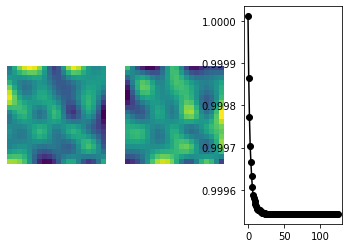

In [210]:
fig, ax = plt.subplots(1,3)
for i in range(2):
    ax[i].imshow(kms.W[:, i].reshape(dims))
    ax[i].axis('off')
    
ax[2].plot(kms.cost[1:], 'ko-')

array([[-0.01928944,  0.05881252, -0.09850016],
       [ 0.04801219,  0.05354084, -0.16688277],
       [-0.10604042, -0.01124305, -0.06489077],
       ...,
       [ 0.1160989 ,  0.00267824,  0.11995255],
       [-0.01515608, -0.00019542, -0.06260602],
       [-0.03071579, -0.04011083, -0.16252977]])

In [48]:
np.sort(np.random.choice(range(1500), 3))

array([ 398,  472, 1124])